In [1]:
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

In [17]:
import torch
import pandas as pd
import numpy as np
import ptls

from hydra import initialize, compose
from hydra.utils import instantiate

from src.datasets.splitters import SampleLength

from src.preprocessing import preprocess

from ptls.frames.coles import ColesDataset
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.nn.seq_encoder import RnnSeqEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from ipywidgets import interactive

In [3]:
from typing import Any

from ptls.data_load.padded_batch import PaddedBatch

def is_seq_feature(k: str, v: Any) -> bool:
    if k == "event_time":
        return True
    if k.startswith("target"):
        return False
    if type(v) in (np.ndarray, torch.Tensor):
        return True 
    return False


def sliding_window_sampler(
    padded_batch: PaddedBatch,
    seq_len: int,
    stride: int = 1,
    time_col: str = "event_time",
) -> dict[str, torch.Tensor]:
    """Sample sliding windows from the raw dataset on-the-fly.

    Args:
        padded_batch (PaddedBatch) - batch with raw input data in ptls format
        seq_len (int) - size of the sliding widow
        stride (int) - stride for sliding window procedure
        time_col (str) - name of the column containg timestamps

    Returns:
        a dictionary of the form (feature_name, feature_values)
    """
    times_batch = padded_batch.payload[time_col]
    bs, date_len = times_batch.shape
    date_range = np.arange(date_len)

    # starting positions for all the windows
    start_pos = date_range[0 : date_len - seq_len + 1 : stride]

    # list of lists of indices of the windows elements
    idxs_list = [date_range[s : s + seq_len] for s in start_pos]

    splits = {
        k: torch.stack([v[:, ix] for ix in idxs_list])
        .transpose(0, 1)
        .reshape(-1, seq_len)
        for k, v in padded_batch.payload.items()
        if is_seq_feature(k, v)
    }

    # convert into PaddedBatch format
    lengths = torch.ones(len(idxs_list) * bs, dtype=torch.int, device=times_batch.device) * seq_len
    collated_batch = PaddedBatch(splits, lengths)

    return collated_batch

In [4]:
np.random.seed(42)

In [5]:
with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="master", overrides=["backbone=coles_churn"])
cfg_preprop = cfg["preprocessing"]
cfg_model = cfg["backbone"]

In [6]:
# cfg_preprop["source"] = "data/preprocessed_new/churn_with_currency.parquet"
# cfg_preprop["val_size"] = 0.01
# cfg_preprop["test_size"] = 0.1
# FOR CURRENCY CPD

In [7]:
N_SAMPLES = 500
MIN_LEN = 80

SAMPLING_LEN = 10

cfg_model["datamodule"]["train_batch_size"] = N_SAMPLES
cfg_model["datamodule"]["valid_batch_size"] = N_SAMPLES

# cfg_dataset["splitter"] = {"_target_": "ptls.frames.coles.split_strategy.NoSplit"}
# cfg_dataset["splitter"] = {"_target_": "src.coles.datamodule.SampleLength", "length": MIN_LEN}
# cfg_dataset["min_len"] = MIN_LEN

### Load & embed data

In [8]:
train, val, test = preprocess(cfg_preprop)
test = val + test

In [9]:
splitter = ptls.frames.coles.split_strategy.NoSplit() 
# splitter = SampleLength(length=MIN_LEN)

train_data = ColesDataset(data=MemoryMapDataset(train, [SeqLenFilter(MIN_LEN)]), splitter=splitter)
test_data = ColesDataset(data=MemoryMapDataset(test, [SeqLenFilter(MIN_LEN)]), splitter=splitter)

train_dl = torch.utils.data.DataLoader(
        dataset=train_data,
        collate_fn=train_data.collate_fn,
        num_workers=0,
        batch_size=cfg_model["datamodule"]["train_batch_size"],
        drop_last=True,
        shuffle=False)

test_dl = torch.utils.data.DataLoader(
        dataset=test_data,
        collate_fn=test_data.collate_fn,
        shuffle=False,
        num_workers=0,
        batch_size=cfg_model["datamodule"]["train_batch_size"],
        drop_last=True,
    )

test_i, train_i = iter(test_dl), iter(train_dl)


In [18]:
model: RnnSeqEncoder = instantiate(cfg_model["encoder"])
model.to("cuda")

RnnSeqEncoder(
  (trx_encoder): TrxEncoder(
    (embeddings): ModuleDict(
      (mcc_code): NoisyEmbedding(
        345, 24, padding_idx=0
        (dropout): Dropout(p=0, inplace=False)
      )
    )
    (numeric_values): ModuleDict(
      (amount): IdentityScaler()
    )
    (numerical_batch_norm): RBatchNormWithLens(
      (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (seq_encoder): RnnEncoder(
    (rnn): LSTM(25, 1024, batch_first=True)
    (reducer): LastStepEncoder()
  )
)

In [19]:
# model.seq_encoder.load_state_dict(torch.load("saved_models/coles_default_3.pth"))
model.load_state_dict(torch.load("saved_models/coles_churn_yugay.pth"))

<All keys matched successfully>

In [20]:
train_b = next(train_i)

In [21]:
train_idx = np.arange(len(train_b[0].payload["event_time"]))
train_emb = model(sliding_window_sampler(train_b[0].to("cuda"), seq_len=SAMPLING_LEN)).detach().cpu().numpy().reshape((N_SAMPLES, -1, 1024))

# test_idx = np.arange(len(test_b[0].payload["event_time"]))
# test_emb = model(sliding_window_sampler(test_b[0].to("cuda"), seq_len=SAMPLING_LEN)).detach().cpu().numpy().reshape((N_SAMPLES, -1, 1024))

In [22]:
train_emb.shape

(500, 71, 1024)

### Clustering & visualization

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#### User dynamics, no clusters

In [16]:
DELTA = 5
def plot_tsne(perplexity=N_SAMPLES-1, n_pca=5, timestamp=0):
    relevant_emb = train_emb[:, timestamp:timestamp + DELTA, :]
    relevant_emb = np.reshape(relevant_emb, (DELTA * len(train_emb), -1))

    pca = PCA(n_components=n_pca)
    pc = pca.fit_transform(relevant_emb)

    tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(pc)

    data = pd.DataFrame(tsne, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in train_idx for _ in range(DELTA)]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False)
    ax.set_title('Visualized TSNE, train')
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [17]:
interactive_plot = interactive(plot_tsne, perplexity=(1., N_SAMPLES-1), timestamp=(0, MIN_LEN-DELTA-1))

In [18]:
interactive_plot

interactive(children=(FloatSlider(value=15.0, description='perplexity', max=15.0, min=1.0), IntSlider(value=5,…

In [22]:
DELTA = 5
def plot_test_tsne(perplexity=N_SAMPLES-1, n_pca=5, timestamp=0):
    relevant_emb = test_emb[:, timestamp:timestamp + DELTA, :]
    relevant_emb = np.reshape(relevant_emb, (DELTA * len(test_emb), -1))

    pca = PCA(n_components=n_pca)
    pc = pca.fit_transform(relevant_emb)

    tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(pc)

    data = pd.DataFrame(tsne, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in test_idx for _ in range(DELTA)]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False)
    ax.set_title('Visualized TSNE, test')
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [23]:
interactive_plot = interactive(plot_test_tsne, perplexity=(1., N_SAMPLES-1), timestamp=(0, MIN_LEN-DELTA-1))

In [24]:
interactive_plot

interactive(children=(FloatSlider(value=15.0, description='perplexity', max=15.0, min=1.0), IntSlider(value=5,…

In [25]:
DELTA = 5
def plot_train_pca(timestamp=0):
    relevant_emb = train_emb[:, timestamp:timestamp + DELTA, :]
    relevant_emb = np.reshape(relevant_emb, (DELTA * len(train_emb), -1))

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in test_idx for _ in range(DELTA)]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False)
    ax.set_title('Visualized PCA, train')
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [26]:
interactive_plot = interactive(plot_train_pca, timestamp=(0, MIN_LEN-DELTA-1))

In [27]:
interactive_plot

interactive(children=(IntSlider(value=0, description='timestamp', max=194), Output(outputs=({'output_type': 'd…

In [28]:
DELTA = 5
def plot_test_pca(timestamp=0):
    relevant_emb = test_emb[:, timestamp:timestamp + DELTA, :]
    relevant_emb = np.reshape(relevant_emb, (DELTA * len(test_emb), -1))

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in test_idx for _ in range(DELTA)]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False)
    ax.set_title('Visualized PCA, test')
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [29]:
interactive_plot = interactive(plot_test_pca, timestamp=(0, MIN_LEN-DELTA-1))

In [30]:
interactive_plot

interactive(children=(IntSlider(value=0, description='timestamp', max=194), Output(outputs=({'output_type': 'd…

#### Cluster-wise user dynamics

In [42]:
def build_clusters(emb, reference_timestamp=0, n_clusters=10):
    relevant_emb = emb[:, reference_timestamp, :]
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    labels = kmeans.fit_predict(relevant_emb)

    return labels

In [43]:
T = 40
N_CLUSTERS = 2
labels = build_clusters(train_emb, T, N_CLUSTERS)

def plot_pca(timestamp=0):
    relevant_emb = train_emb[:, timestamp, :]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in labels]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False)
    ax.set_title(f"Visualized PCA train, cluster-wise, n_clusters={N_CLUSTERS}, reference timestamp={T}")
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [44]:
interactive_plot = interactive(plot_pca, timestamp=(T, MIN_LEN-DELTA-1))

In [45]:
interactive_plot

interactive(children=(IntSlider(value=40, description='timestamp', max=194, min=40), Output(outputs=({'output_…

In [46]:
T = 40
N_CLUSTERS = 2
labels = build_clusters(test_emb, T, N_CLUSTERS)

def plot_test_pca(timestamp=0):
    relevant_emb = test_emb[:, timestamp, :]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in labels]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False)
    ax.set_title(f"Visualized PCA test, cluster-wise, n_clusters={N_CLUSTERS}, reference timestamp={T}")
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [47]:
interactive_plot = interactive(plot_test_pca, timestamp=(T, MIN_LEN-DELTA-1))

In [48]:
interactive_plot

interactive(children=(IntSlider(value=40, description='timestamp', max=194, min=40), Output(outputs=({'output_…

#### Proximity-based labels

In [49]:
def build_closest(emb, reference_timestamp=0, num_closest=100):
    reference_idx = np.random.randint(0, len(emb))

    relevant_emb = emb[:, reference_timestamp, :]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    reference_emb = pc[reference_idx]

    distances = [(np.linalg.norm(emb - reference_emb), idx) for idx, emb in enumerate(pc)]
    distances = sorted(distances, key=lambda elem: elem[0])

    labels = np.zeros(len(relevant_emb))
    labels[reference_idx] = 2
    for i in range(1, num_closest):
        labels[distances[i][1]] = 1

    return labels

In [50]:
T = 40
N_CLOSEST = 50

labels = build_closest(train_emb, T, N_CLOSEST)

def plot_proximity_pca(timestamp=0):
    relevant_emb = train_emb[:, timestamp, :]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = labels

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", size="label", ax=ax, legend=False, palette=sns.color_palette("husl", 3))
    ax.set_title(f"Visualized PCA, n_closest={N_CLOSEST}, reference timestamp={T}")
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [51]:
interactive_plot = interactive(plot_proximity_pca, timestamp=(T, MIN_LEN-1))

In [52]:
interactive_plot

interactive(children=(IntSlider(value=40, description='timestamp', max=199, min=40), Output(outputs=({'output_…

In [53]:
T = 40
N_CLOSEST = 50
labels = build_closest(test_emb, T, N_CLOSEST)

def plot_proximity_test_pca(timestamp=0):
    relevant_emb = test_emb[:, timestamp, :]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = labels

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", size="label", ax=ax, legend=False, palette=sns.color_palette("husl", 3))
    ax.set_title(f"Visualized PCA test, n_closest={N_CLOSEST}, reference timestamp={T}")
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [54]:
interactive_plot = interactive(plot_proximity_test_pca, timestamp=(T, MIN_LEN-1))

In [55]:
interactive_plot

interactive(children=(IntSlider(value=40, description='timestamp', max=199, min=40), Output(outputs=({'output_…

#### Masking

In [14]:
from ptls.data_load.padded_batch import PaddedBatch

def insert_mask(t: torch.Tensor, r: torch.Tensor, pos: int = 30, length: int = 30):
    r = torch.nn.functional.pad(r, (0, t.shape[1] - r.shape[1], 0, 0))

    mask = torch.zeros_like(t).bool()
    mask[:, pos: pos + length] = True

    res = torch.where(mask, r, t)
    return res

def masking(train_b: PaddedBatch, reference_b: PaddedBatch, pos: int = 30, length: int = 40):
    payload = {
        k: insert_mask(v, reference_b.payload[k], pos=pos, length=length)
        for k, v in train_b.payload.items()
        if is_seq_feature(k, v)
    }

    return PaddedBatch(payload=payload, length=train_b.seq_lens)

In [15]:
train_b, test_b = next(train_i), next(test_i)

In [43]:
MASK_POS = 40
MASK_LEN = 40

masked_batch = masking(train_b[0], test_b[0], pos=MASK_POS, length=MASK_LEN)

train_idx = np.arange(len(masked_batch.payload["event_time"]))
masked_emb = model(sliding_window_sampler(masked_batch.to("cuda"), seq_len=SAMPLING_LEN)).detach().cpu().reshape((N_SAMPLES, -1, 1024))
unmasked_emb = model(sliding_window_sampler(train_b[0].to("cuda"), seq_len=SAMPLING_LEN)).detach().cpu().reshape((N_SAMPLES, -1, 1024))

In [44]:
masked_emb.shape

torch.Size([500, 71, 1024])

##### Mean distance plot

In [45]:
from torch.nn import CosineSimilarity
from matplotlib import pyplot as plt

In [46]:
cos = CosineSimilarity(dim=-1)
cosine_distances = cos(masked_emb, unmasked_emb)

In [47]:
cosine_distances.mean(dim=0).shape

torch.Size([71])

In [48]:
torch.save(cosine_distances, 'cos_similarities_coles.pt')

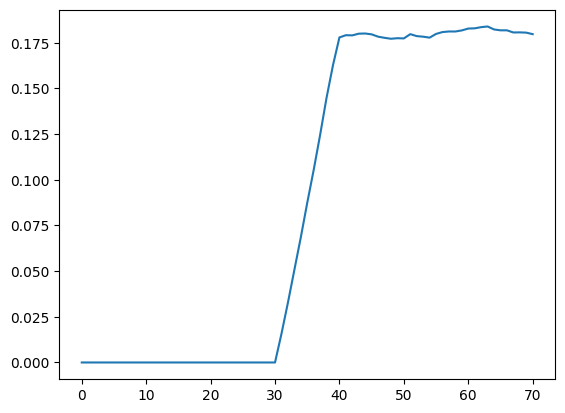

In [49]:
plt.plot(1 - cosine_distances.mean(dim=0))
plt.show()

##### Interactive picture

In [49]:
i = 0
labels = np.arange(len(masked_emb))
labels = np.concatenate((labels, labels))

def plot_masking_pca(perplexity=N_SAMPLES - 1, n_pca=5, timestamp=0):
    relevant_emb = unmasked_emb[:, timestamp, :]
    masked_relevant_emb = masked_emb[:, timestamp, :]

    relevant_emb = np.vstack((relevant_emb, masked_relevant_emb))
    
    pca = PCA(n_components=5)
    pc = pca.fit_transform(relevant_emb)

    tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(pc)

    data = pd.DataFrame(tsne, columns=["x1", "x2"])
    data["label"] = labels

    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    sns.scatterplot(data=data[:len(masked_emb)], x="x1", y="x2", hue="label", ax=ax, legend=False, palette=sns.color_palette("husl", len(masked_emb)))
    sns.scatterplot(data=data[len(masked_emb):], x="x1", y="x2", hue="label", ax=ax, legend=False, palette=sns.color_palette("husl", len(masked_emb)), marker='x')
    ax.set_title(f"Visualized TSNE, mask_len={MASK_LEN}, seq_len={SAMPLING_LEN}")
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [85]:
interactive_plot = interactive(plot_masking_pca, perplexity=(1., N_SAMPLES-1), timestamp=(0, MIN_LEN-1))

In [86]:
interactive_plot # picture should start diverging at ~ 75 and converging at ~ 87

interactive(children=(FloatSlider(value=7.0, description='perplexity', max=7.0, min=1.0), IntSlider(value=5, d…

##### The static picture for the presentation

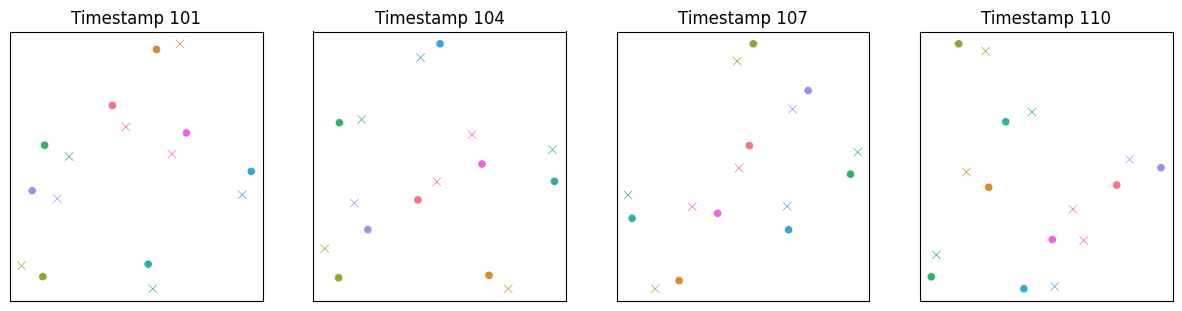

In [50]:
# from 75 to 115
timestamps = [76, 79, 82, 85]
perplexity=5

fig, ax = plt.subplots(1, 4, figsize=(15,3.5))

for i, timestamp in enumerate(timestamps):
    relevant_emb = unmasked_emb[:, timestamp, :]
    masked_relevant_emb = masked_emb[:, timestamp, :]

    relevant_emb = np.vstack((relevant_emb, masked_relevant_emb))

    pca = PCA(n_components=5)
    pc = pca.fit_transform(relevant_emb)

    tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(pc)

    data = pd.DataFrame(tsne, columns=["x1", "x2"])
    data["label"] = labels

    
    sns.scatterplot(data=data[:len(masked_emb)], x="x1", y="x2", hue="label", ax=ax[i], legend=False, palette=sns.color_palette("husl", len(masked_emb)))
    sns.scatterplot(data=data[len(masked_emb):], x="x1", y="x2", hue="label", ax=ax[i], legend=False, palette=sns.color_palette("husl", len(masked_emb)), marker='x')
    ax[i].set_title(f"Timestamp {timestamp + SAMPLING_LEN}")
    ax[i].set(xlabel=None, ylabel=None)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.plot()
plt.show()

### Target-based clusterization

In [27]:
def build_target_labels(data):
    return data.payload["churn_target"].sum(axis=-1) > 0

In [32]:
T = 40

labels = build_target_labels(train_b[0])

def plot_targets_pca(timestamp=0):
    relevant_emb = train_emb[:, timestamp, :]

    pca = PCA(n_components=2)
    pc = pca.fit_transform(relevant_emb)

    data = pd.DataFrame(pc, columns=["x1", "x2"])
    data["label"] = [str(elem) for elem in labels]

    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, legend=False, palette=sns.color_palette("husl", 2))
    ax.set_title(f"Visualized PCA,reference timestamp={T}")
    plt.xticks([]),plt.yticks([])
    ax.set(xlabel=None, ylabel=None)
    plt.plot()

In [33]:
interactive_plot = interactive(plot_targets_pca, timestamp=(T, MIN_LEN-1))

In [34]:
interactive_plot

interactive(children=(IntSlider(value=40, description='timestamp', max=199, min=40), Output(outputs=({'output_…

### Plot CPs

In [19]:
cnt, max_cnt = 0, 0
# currencies = train_b[0].payload["currency"].squeeze()
currencies = train[0]["currency"]
for i in range(len(currencies)):
    if currencies[i] == 840:
        cnt += 1
    else:
        max_cnt = max(cnt, max_cnt)
        cnt = 0

In [20]:
train[0]["currency"]

tensor([810, 810, 810, 810, 810, 810, 810, 810, 810, 840, 840, 810, 810, 810,
        810, 810, 810, 810, 810, 840, 840, 840, 840, 840, 840, 840, 840, 840,
        840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 810, 840,
        840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 840, 810,
        840, 840, 840, 840, 840, 810, 840, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 840, 840,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810,
        810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 8

In [21]:
max_cnt

21

In [19]:
from sklearn import svm

In [20]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

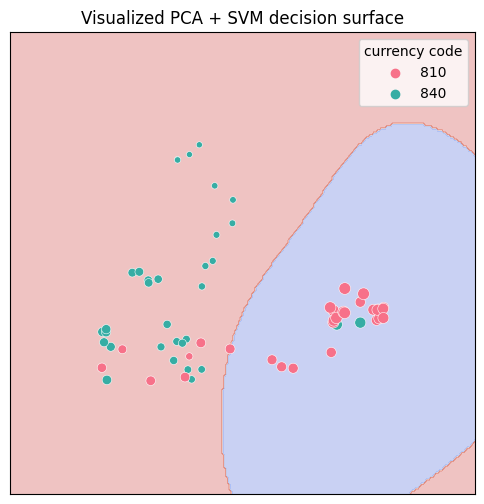

In [23]:
pca = PCA(n_components=2)
pc = pca.fit_transform(train_emb.squeeze()[20:84])


data = pd.DataFrame(pc, columns=["x1", "x2"])
data["label"] = train_b[0].payload["currency"].squeeze()[20 + SAMPLING_LEN - 1:SAMPLING_LEN - 1 + 84]
size = 2 * np.arange(1, 1 + len(data))

model = svm.SVC(kernel='rbf')
clf = model.fit(pc, data["label"])

X0, X1 = pc[:, 0], pc[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3)
sns.scatterplot(data=data, x="x1", y="x2", hue="label", ax=ax, size=size, palette=sns.color_palette("husl", 2))
h, l = ax.get_legend_handles_labels()
plt.legend(h[0:2], l[0:2], loc="best", title='currency code')
ax.set_title(f"Visualized PCA + SVM decision surface")
plt.xticks([]),plt.yticks([])
ax.set(xlabel=None, ylabel=None)
plt.plot()
plt.show()